In [12]:
# See requirements.txt to set up your dev environment.
import os
import sys
import utm
import json
import scipy
import overpy
import urllib
import datetime 
import urllib3
import rasterio
import subprocess
import numpy as np
import pandas as pd
import seaborn as sns
from osgeo import gdal
from planet import api
from planet.api import filters
from traitlets import link
import rasterio.tools.mask as rio_mask
from shapely.geometry import mapping, shape
from IPython.display import display, Image, HTML
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#from scipy import ndimage
import warnings
from osgeo import gdal
from osmapi import OsmApi
#http://python-overpy.readthedocs.io/en/latest/introduction.html
# http://overpass-turbo.eu/# <- construct nice queries
from geopy.geocoders import Nominatim
# GDAL does not use python exceptions by default


urllib3.disable_warnings()
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

%matplotlib inline
# will pick up api_key via environment variable PL_API_KEY
# but can be specified using `api_key` named argument
api_keys = json.load(open("apikeys.json",'r'))
client = api.ClientV1(api_key=api_keys["PLANET_API_KEY"])
gdal.UseExceptions()
api = overpy.Overpass()

In [13]:
#run this to get something we can render or use the visual product
#gdal_translate -ot Byte -scale 0 4096 0 255 /home/kat/code/hacking/osm/20170222_231253_0c27/20170222_231253_0c27_3B_AnalyticMS.tif test.tif

In [14]:
# Basemap Mosaic (v1 API)
mosaicsSeries = 'global_quarterly_2017q1_mosaic'
# Planet tile server base URL (Planet Explorer Mosaics Tiles)
mosaicsTilesURL_base = 'https://tiles0.planet.com/experimental/mosaics/planet-tiles/' + mosaicsSeries + '/gmap/{z}/{x}/{y}.png'
# Planet tile server url
mosaicsTilesURL = mosaicsTilesURL_base + '?api_key=' + api_keys["PLANET_API_KEY"]
# Map Settings 
# Define colors
colors = {'blue': "#009da5"}
# Define initial map center lat/long
center = [45.5231, -122.6765]
# Define initial map zoom level
zoom = 13
# Set Map Tiles URL
planetMapTiles = TileLayer(url= mosaicsTilesURL)
# Create the map
m = Map(
    center=center, 
    zoom=zoom,
    default_tiles = planetMapTiles # Uncomment to use Planet.com basemap
)
# Define the draw tool type options
polygon = {'shapeOptions': {'color': colors['blue']}}
rectangle = {'shapeOptions': {'color': colors['blue']}} 

# Create the draw controls
# @see https://github.com/ellisonbg/ipyleaflet/blob/master/ipyleaflet/leaflet.py#L293
dc = DrawControl(
    polygon = polygon,
    rectangle = rectangle
)
# Initialize an action counter variable
actionCount = 0
AOIs = {}

# Register the draw controls handler
def handle_draw(self, action, geo_json):
    # Increment the action counter
    global actionCount
    actionCount += 1
    # Remove the `style` property from the GeoJSON
    geo_json['properties'] = {}
    # Convert geo_json output to a string and prettify (indent & replace ' with ")
    geojsonStr = json.dumps(geo_json, indent=2).replace("'", '"')
    AOIs[actionCount] = json.loads(geojsonStr)
    
# Attach the draw handler to the draw controls `on_draw` event
dc.on_draw(handle_draw)
m.add_control(dc)
m

In [16]:
print AOIs[1]
myAOI = AOIs[1]["geometry"]

# build a query using the AOI and
# a cloud_cover filter that excludes 'cloud free' scenes

old = datetime.datetime(year=2013,month=1,day=1)

query = filters.and_filter(
    filters.geom_filter(myAOI),
    filters.range_filter('cloud_cover', gt=0),
    filters.date_range('acquired', gt=old)
)

# build a request for only PlanetScope imagery
request = filters.build_search_request(
    query, item_types=['PSScene3Band']
)

# if you don't have an API key configured, this will raise an exception
result = client.quick_search(request)
scenes = []
planet_map = {}
for item in result.items_iter(limit=500):
    planet_map[item['id']]=item
    props = item['properties']
    props["id"] = item['id']
    props["geometry"] = item["geometry"]
    props["thumbnail"] = item["_links"]["thumbnail"]
    scenes.append(props)
scenes = pd.DataFrame(data=scenes)
# now let's clean up the datetime stuff
# make a shapely shape from our aoi
portland = shape(myAOI)
footprints = []
overlaps = []
# go through the geometry from our api call, convert to a shape and calculate overlap area.
# also save the shape for safe keeping
for footprint in scenes["geometry"].tolist():
    s = shape(footprint)
    footprints.append(s)
    overlap = 100.0*(portland.intersection(s).area / portland.area)
    overlaps.append(overlap)
# take our lists and add them back to our dataframe
scenes['overlap'] = pd.Series(overlaps, index=scenes.index)
scenes['footprint'] = pd.Series(footprints, index=scenes.index)
# now make sure pandas knows about our date/time columns.
scenes["acquired"] = pd.to_datetime(scenes["acquired"])
scenes["published"] = pd.to_datetime(scenes["published"])
scenes["updated"] = pd.to_datetime(scenes["updated"])
# now let's clean up the datetime stuff
# make a shapely shape from our aoi
portland = shape(myAOI)
footprints = []
overlaps = []
# go through the geometry from our api call, convert to a shape and calculate overlap area.
# also save the shape for safe keeping
for footprint in scenes["geometry"].tolist():
    s = shape(footprint)
    footprints.append(s)
    overlap = 100.0*(portland.intersection(s).area / portland.area)
    overlaps.append(overlap)
# take our lists and add them back to our dataframe
scenes['overlap'] = pd.Series(overlaps, index=scenes.index)
scenes['footprint'] = pd.Series(footprints, index=scenes.index)
# now make sure pandas knows about our date/time columns.
scenes["acquired"] = pd.to_datetime(scenes["acquired"])
scenes["published"] = pd.to_datetime(scenes["published"])
scenes["updated"] = pd.to_datetime(scenes["updated"])
scenes.head()

# first create a list of colors
colors = ["#ff0000","#00ff00","#0000ff","#ffff00","#ff00ff","#00ffff"]
# grab our scenes from the geometry/footprint geojson
footprints = scenes["geometry"].tolist()
# for each footprint/color combo
for footprint,color in zip(footprints[0:1],colors[0:1]):
    # create the leaflet object
    feat = {'geometry':footprint,"properties":{
            'style':{'color': color,'fillColor': color,'fillOpacity': 0.2,'weight': 1}},
            'type':u"Feature"}
    # convert to geojson
    gjson = GeoJSON(data=feat)
    # add it our map
    m.add_layer(gjson)
# now we will draw our original AOI on top 
feat = {'geometry':myAOI,"properties":{
            'style':{'color': "#FFFFFF",'fillColor': "#FFFFFF",'fillOpacity': 0.5,'weight': 1}},
            'type':u"Feature"}
gjson = GeoJSON(data=feat)
m.add_layer(gjson)   
m 



{u'geometry': {u'type': u'Polygon', u'coordinates': [[[-122.69685745239258, 45.51093712010877], [-122.69685745239258, 45.53871856124494], [-122.65703201293947, 45.53871856124494], [-122.65703201293947, 45.51093712010877], [-122.69685745239258, 45.51093712010877]]]}, u'type': u'Feature', u'properties': {}}


In [17]:
def get_products(client, scene_id, asset_type='PSScene3Band'):    
    """
    Ask the client to return the available products for a 
    given scene and asset type. Returns a list of product 
    strings
    """
    out = client.get_assets_by_id(asset_type,scene_id)
    temp = out.get()
    return temp.keys()

def activate_product(client, scene_id, asset_type="PSScene3Band",product="analytic"):
    """
    Activate a product given a scene, an asset type, and a product.
    
    On success return the return value of the API call and an activation object
    """
    temp = client.get_assets_by_id(asset_type,scene_id)  
    products = temp.get()
    if( product in products.keys() ):
        return client.activate(products[product]),products[product]
    else:
        return None 

def download_and_save(client,product):
    """
    Given a client and a product activation object download the asset. 
    This will save the tiff file in the local directory and return its 
    file name. 
    """
    out = client.download(product)
    fp = out.get_body()
    fp.write()
    return fp.name

def scenes_are_active(scene_list):
    """
    Check if all of the resources in a given list of
    scene activation objects is read for downloading.
    """
    retVal = True
    for scene in scene_list:
        if scene["status"] != "active":
            print "{} is not ready.".format(scene)
            return False
    return True

In [18]:
to_get = scenes["id"][0:1].tolist()
activated = []
# for each scene to get
for scene in to_get:
    # get the product 
    product_types = get_products(client,scene)
    for p in product_types:
        # if there is a visual product
        if p == "visual": # p == "basic_analytic_dn"
            print "Activating {0} for scene {1}".format(p,scene)
            # activate the product
            _,product = activate_product(client,scene,product=p)
            activated.append(product)

Activating visual for scene 20170503_181522_0f35


In [19]:
tiff_files = []
asset_type = "_3B_Visual"
# check if our scenes have been activated
if scenes_are_active(activated):
    for to_download,name in zip(activated,to_get):
        # create the product name
        name = name + asset_type + ".tif"
        # if the product exists locally
        if( os.path.isfile(name) ):
            # do nothing 
            print "We have scene {0} already, skipping...".format(name)
            tiff_files.append(name)
        elif to_download["status"] == "active":
            # otherwise download the product
            print "Downloading {0}....".format(name)
            fname = download_and_save(client,to_download)
            tiff_files.append(fname)
            print "Download done."
        else:
            print "Could not download, still activating"
else:
    print "Scenes aren't ready yet"

print tiff_files 

We have scene 20170503_181522_0f35_3B_Visual.tif already, skipping...
[u'20170503_181522_0f35_3B_Visual.tif']


In [20]:
infile = tiff_files[0]
#infile = "/home/kat/code/hacking/PythonFromSpace/test.tif"
gtif = gdal.Open(infile)
print gtif.GetProjectionRef()
arr = gtif.ReadAsArray()
trans = gtif.GetGeoTransform()
print trans

extent = (trans[0], trans[0] + gtif.RasterXSize*trans[1],
          trans[3] + gtif.RasterYSize*trans[5], trans[3])
pos = [8000,3000] # this is the pixel we want info about


PROJCS["WGS 84 / UTM zone 10N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-123],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32610"]]
(499827.0, 3.0, 0.0, 5051880.0, 0.0, -3.0)


In [49]:
def pixel2utm(ds, x, y):
    """
    Returns utm coordinates from pixel x, y coords
    """
    xoff, a, b, yoff, d, e = ds.GetGeoTransform()
    xp = a * x + b * y + xoff
    yp = d * x + e * y + yoff
    return(xp, yp)

def draw_point(x,y,img):
    t = 20
    img[y-t:y+t,x-t:x+t,:] = [255,0,0]

In [50]:
ds = gdal.Open(infile)
# take the GDAL info and make it into UTM
my_utm = pixel2utm(ds,pos[0],pos[1])
# convert UTM into Lat Long
# need to figure out how to get zone info
my_lla = utm.to_latlon(my_utm[0],my_utm[1],10,"N")
# do the lat long look up from OSM
geolocator = Nominatim()
# reverse look up the are based on lat lon
location = geolocator.reverse("{0},{1}".format(my_lla[0],my_lla[1]))
# print location info
print location.address
print location.raw
# get the OSM ID info
osm_id = int(location.raw["place_id"])
print osm_id
# create an interface to the OSM API
MyApi = OsmApi()
# Look up our position 
print MyApi.NodeGet(osm_id)


2100, Northwest York Street, Kings Heights, Portland, Multnomah County, Oregon, 97210, United States of America
{u'display_name': u'2100, Northwest York Street, Kings Heights, Portland, Multnomah County, Oregon, 97210, United States of America', u'place_id': u'51222581', u'lon': u'-122.6954719', u'boundingbox': [u'45.5393314', u'45.5395314', u'-122.6955719', u'-122.6953719'], u'osm_type': u'node', u'licence': u'Data \xa9 OpenStreetMap contributors, ODbL 1.0. http://www.openstreetmap.org/copyright', u'osm_id': u'3717724833', u'lat': u'45.5394314', u'address': {u'city': u'Portland', u'house_number': u'2100', u'country': u'United States of America', u'county': u'Multnomah County', u'suburb': u'Kings Heights', u'state': u'Oregon', u'postcode': u'97210', u'country_code': u'us', u'road': u'Northwest York Street'}}
51222581
{u'changeset': 13824254, u'uid': 313700, u'timestamp': datetime.datetime(2012, 11, 10, 18, 32, 12), u'lon': -105.3243166, u'visible': True, u'version': 3, u'user': u'JoeGr

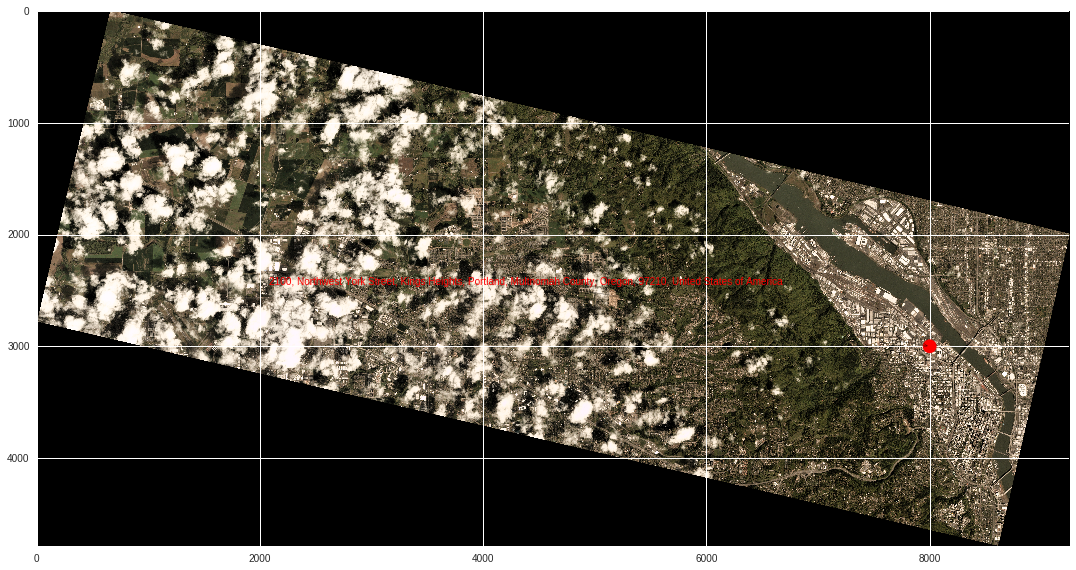

In [51]:
from matplotlib.patches import Circle
fig,ax = plt.subplots(1)

plt.imshow(arr[:3,:,:].transpose((1, 2, 0)))#, extent=extent)
fig = plt.gcf()
plt.annotate(location.address, xy=pos, xycoords='data',
             xytext=(0.25, 0.5), textcoords='figure fraction',color="red",
             arrowprops=dict(arrowstyle="->"))
ax.set_aspect('equal')
circ = Circle((pos[0],pos[1]),60,color="red")
ax.add_patch(circ)
fig.set_size_inches(18.5, 10.5)
plt.show()

In [54]:
# Basemap Mosaic (v1 API)
mosaicsSeries = 'global_quarterly_2017q1_mosaic'
# Planet tile server base URL (Planet Explorer Mosaics Tiles)
mosaicsTilesURL_base = 'https://tiles0.planet.com/experimental/mosaics/planet-tiles/' + mosaicsSeries + '/gmap/{z}/{x}/{y}.png'
# Planet tile server url
mosaicsTilesURL = mosaicsTilesURL_base + '?api_key=' + api_keys["PLANET_API_KEY"]
# Map Settings 
# Define colors
colors = {'blue': "#009da5"}
# Define initial map center lat/long
center = [45.5231, -122.6765]
# Define initial map zoom level
zoom = 13
# Set Map Tiles URL
planetMapTiles = TileLayer(url= mosaicsTilesURL)
# Create the map
m = Map(
    center=center, 
    zoom=zoom,
    default_tiles = planetMapTiles # Uncomment to use Planet.com basemap
)
# Define the draw tool type options
polygon = {'shapeOptions': {'color': colors['blue']}}
rectangle = {'shapeOptions': {'color': colors['blue']}} 

# Create the draw controls
# @see https://github.com/ellisonbg/ipyleaflet/blob/master/ipyleaflet/leaflet.py#L293
dc = DrawControl(
    polygon = polygon,
    rectangle = rectangle
)
# Initialize an action counter variable
actionCount = 0
AOIs = {}

# Register the draw controls handler
def handle_draw(self, action, geo_json):
    # Increment the action counter
    global actionCount
    actionCount += 1
    # Remove the `style` property from the GeoJSON
    geo_json['properties'] = {}
    # Convert geo_json output to a string and prettify (indent & replace ' with ")
    geojsonStr = json.dumps(geo_json, indent=2).replace("'", '"')
    AOIs[actionCount] = json.loads(geojsonStr)
    
# Attach the draw handler to the draw controls `on_draw` event
dc.on_draw(handle_draw)
m.add_control(dc)
m

In [64]:
def get_osm_data(lat,lon):
    retVal = {}
    geolocator = Nominatim()
    MyApi = OsmApi()
    location = geolocator.reverse("{0},{1}".format(lat,lon))
    retVal["address"] = location.address
    retVal["id"] = location.raw["place_id"]
    # get the OSM ID info
    #osm_id = int()
    #print osm_id
    # create an interface to the OSM API
    # Look up our position 
    #print MyApi.NodeGet(osm_id)
    return retVal
    
print AOIs[1]
myAOI = AOIs[1]["geometry"]
for pt in myAOI['coordinates']:
    # reverse look up the are based on lat lon
    temp = get_osm_data(pt[1],pt[0])
    print temp["address"]

{u'geometry': {u'type': u'LineString', u'coordinates': [[-122.69805908203125, 45.53621608792505], [-122.66664505004881, 45.53801968350807], [-122.6565170288086, 45.52936189712233], [-122.65445709228516, 45.51288437266618], [-122.67059326171874, 45.50795220451871], [-122.69325256347656, 45.52395010379055]]}, u'type': u'Feature', u'properties': {}}
1848, Northwest 23rd Avenue, Kings Heights, Portland, Multnomah County, Oregon, 97210, United States of America
6, North Tillamook Street, Albina, Portland, Multnomah County, Oregon, 97227, United States of America
830, Northeast Holladay Street, Irvington, Lloyd District, Portland, Multnomah County, Oregon, 97232, United States of America
1120, Southeast Madison Street, Ladd's Addition, Central East Side, Portland, Multnomah County, Oregon, 97214, United States of America
Marquam Bridge, Ladd's Addition, University District, Portland, Multnomah County, Oregon, 97201, United States of America
Fred Meyer, 100, Northwest 20th Place, Pearl Distri

In [ ]:
#https://michelleful.github.io/code-blog/2015/04/27/osm-data/

In [7]:
# https://github.com/jwass/geopandas_osm
# THIS IS THE SHIT! 
import json
import shapely.geometry
import geopandas_osm.osm

with open('downtown.geojson') as f:
    data = json.load(f)

poly = shapely.geometry.shape(data['features'][0]['geometry'])
df = geopandas_osm.osm.query_osm('way', poly, recurse='down')

#roads = df[df.type == 'LineString'][['highway', 'name', 'geometry']]



/usr/local/lib/python2.7/dist-packages/geopandas_osm-0.0.1-py2.7.egg/geopandas_osm/osm.py:299: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  df = df.sort_index(by='index')[['lon', 'lat']]


In [9]:
"""
THIS GETS ALL THE PARKS!!!!
[bbox:{{bbox}}][timeout:1800];
way["leisure"="park"];map_to_area->.a;
foreach(
  (._;>;);
  is_in;
  way(pivot)["leisure"="park"];
  out geom;
);
https://gis.stackexchange.com/questions/89404/how-do-i-convert-open-street-map-export-to-geojson
"""

SyntaxError: invalid syntax (<ipython-input-9-79fd57c40655>, line 1)

In [25]:
# we have the utm of our scene
# which we move to lat long
# now if we can make a bounding box
# we can query all of the coast in that box. 
# Buil the bounding box for the scene
infile = tiff_files[0]
ds = gdal.Open(infile)
print ds.GetProjectionRef()
arr = ds.ReadAsArray()
trans = ds.GetGeoTransform()
print trans

extent = (trans[0], trans[0] + gtif.RasterXSize*trans[1],
          trans[3] + gtif.RasterYSize*trans[5], trans[3])
width = ds.RasterXSize
height = ds.RasterYSize
gt = ds.GetGeoTransform()
xmin = gt[0]
ymin = gt[3] + width * gt[4] + height * gt[5]
xmax = gt[0] + width * gt[1] + height * gt[2]
ymax = gt[3]
array = [xmin, ymin, xmax, ymax]
# This is in utm convert to LLA
tl = utm.to_latlon(xmin,ymin,10,"N")
br = utm.to_latlon(xmax,ymax,10,"N")
# here is the base query
# this thing wants things in the very specific
# format s,w,n,e lat,lon,lat,lonmultpoly
query = """
bbox={0},{1},{2},{3};
[timeout:1800];
way["leisure"="park"];map_to_area->.a;
foreach(
  (._;>;);
  is_in;
  way(pivot)["leisure"="park"];
  out geom;
);
    """
place = query.format(tl[0],tl[1],br[0],br[1])   
print place
result = api.query(place)
print result.nodes

PROJCS["WGS 84 / UTM zone 10N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-123],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32610"]]
(499827.0, 3.0, 0.0, 5051880.0, 0.0, -3.0)

bbox=45.4911743176,-123.002214003,45.6199178692,-122.646309298;
[timeout:1800];
way["leisure"="park"];map_to_area->.a;
foreach(
  (._;>;);
  is_in;
  way(pivot)["leisure"="park"];
  out geom;
);
    


OverpassBadRequest: Error: line 2: parse error: Unknown type "bbox" 
Error: line 2: parse error: An empty query is not allowed 
Error: line 2: parse error: Unknown type "=" 
Error: line 2: parse error: An empty query is not allowed 
Error: line 2: parse error: Unknown type "45.4911743176" 
Error: line 2: parse error: An empty query is not allowed 
Error: line 2: parse error: Unknown type "," 
Error: line 2: parse error: An empty query is not allowed 
Error: line 2: parse error: Unknown type "-123.002214003" 
Error: line 2: parse error: An empty query is not allowed 
Error: line 2: parse error: Unknown type "," 
Error: line 2: parse error: An empty query is not allowed 
Error: line 2: parse error: Unknown type "45.6199178692" 
Error: line 2: parse error: An empty query is not allowed 
Error: line 2: parse error: Unknown type "," 
Error: line 2: parse error: An empty query is not allowed 
Error: line 2: parse error: Unknown type "-122.646309298" 
Error: line 2: parse error: An empty query is not allowed 
Error: line 2: parse error: Unknown type ";" 
Error: line 3: parse error: '!', '~', '=', '!=', or ']'  expected - ':' found. 
Error: line 3: static error: For the attribute "type" of the element "query" the only allowed values are "node", "way", "relation" or "area". 

In [8]:
utm_points = []
for node in result.nodes:
    utm_points.append(utm.from_latlon(node.lat,node.lon))
utm_points
node.from_xml?

In [9]:
    print node.from_xml

<bound method type.from_xml of <class 'overpy.Node'>>


In [53]:
import cv2 
band = gtif.GetRasterBand(1)

cols = gtif.RasterXSize
rows = gtif.RasterYSize

transform = gtif.GetGeoTransform()

xOrigin = transform[0]
yOrigin = transform[3]
pixelWidth = transform[1]
pixelHeight = -transform[5]

data = band.ReadAsArray(0, 0, cols, rows)
arr = gtif.ReadAsArray()
temp = arr[0:3,:,:]
cv2.line(temp, (0,0), (300,300), (0,255,0))

for point in utm_points:
    col = int((point[0] - xOrigin) / pixelWidth)
    row = int((yOrigin - point[1] ) / pixelHeight)
    if( col > 0 and row < 4547 and row > 0 and col < 8929 ):    
        arr[0,row,col] = 255
        arr[1,row,col] = 0
        arr[2,row,col] = 0

plt.imshow(temp[:3,:,:].transpose((1, 2, 0)))#, extent=extent)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

NameError: name 'utm_points' is not defined